In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO SISTEMA NÃO-LINEAR COMPLEXO ---
np.random.seed(42)
n_samples = 2000
input_dim = 2
n_neurons = 5

# Entrada complexa
x = (np.random.randn(n_samples) + 1j * np.random.randn(n_samples)) / np.sqrt(2)

# Planta Desconhecida: Canal com Distorção Não-Linear Complexa
# d[k] = tanh(x[k]) + 0.1 * x[k-1]^2 + ruído
d = np.zeros(n_samples, dtype=complex)
for k in range(1, n_samples):
    # Uma função não-linear complexa arbitrária para teste
    z = x[k] + 0.5 * x[k-1]
    d[k] = np.tanh(z.real) + 1j * np.tanh(z.imag) + 0.1 * (z**2)

# Adiciona ruído complexo
d += 0.02 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

# --- 2. EXECUÇÃO DO FILTRO CRBF ---
# ur: centers update, uw: weights update, us: sigma update
filt = pdf.ComplexRBF(
    n_neurons=n_neurons,
    input_dim=input_dim,
    ur=0.001, 
    uw=0.01,  
    us=0.001,
    sigma_init=2.5
)

result = filt.optimize(x, d, verbose=True, return_internal_states=True)

[ComplexRBF] Completed in 50.178 ms


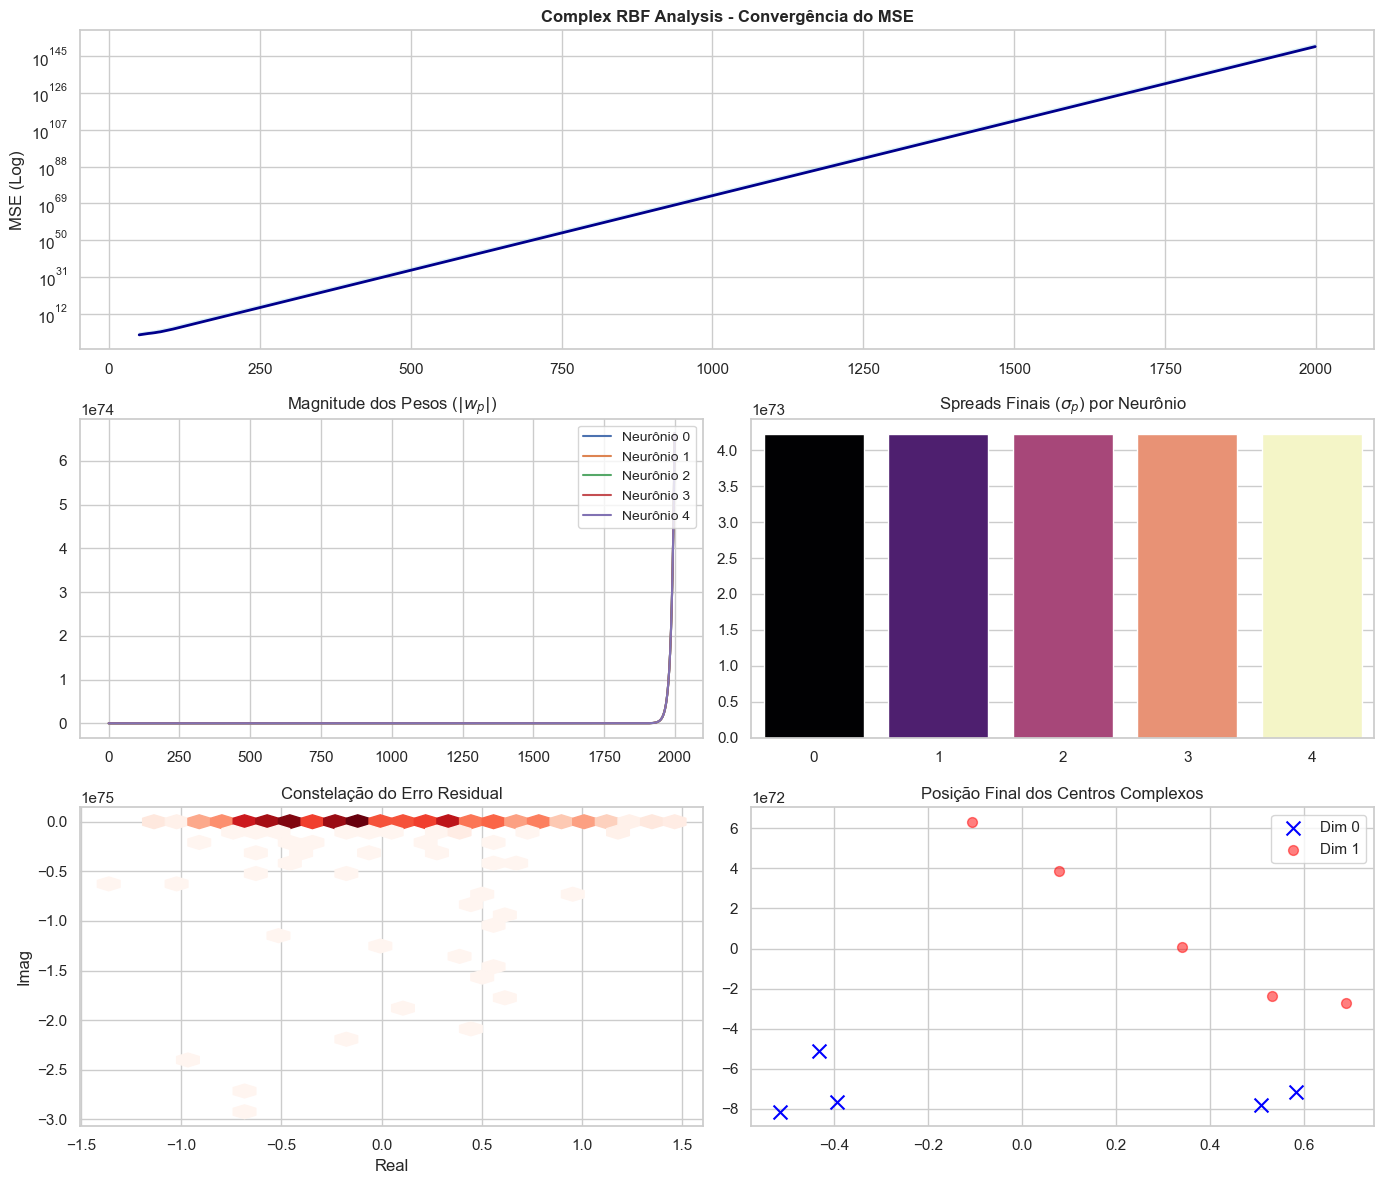

In [8]:
# --- 3. VISUALIZAÇÃO DOS RESULTADOS ---

def plot_crbf_results(result, title):
    sns.set_theme(style="whitegrid")
    mse = result.mse()
    t = np.arange(len(mse))
    
    fig = plt.figure(figsize=(14, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Curva de Aprendizado (MSE)
    ax1 = fig.add_subplot(gs[0, :])
    sns.lineplot(x=t[50:], y=mse[50:], ax=ax1, color="skyblue", alpha=0.3)
    mse_smooth = pd.Series(mse).rolling(window=50).mean()
    sns.lineplot(x=t[50:], y=mse_smooth[50:], ax=ax1, color="darkblue", lw=2)
    ax1.set_yscale('log')
    ax1.set_title(f"{title} - Convergência do MSE", fontweight='bold')
    ax1.set_ylabel("MSE (Log)")

    # B. Evolução dos Pesos dos Neurônios (Magnitude)
    ax2 = fig.add_subplot(gs[1, 0])
    w_hist = result.coefficients[1:]
    for i in range(n_neurons):
        ax2.plot(t, np.abs(w_hist[:, i]), label=f'Neurônio {i}')
    ax2.set_title("Magnitude dos Pesos ($|w_p|$)")
    ax2.legend(loc='upper right', fontsize='small')

    # C. Evolução do Sigma (Espalhamento)
    ax3 = fig.add_subplot(gs[1, 1])
    # Como sigma é atualizado internamente mas não vai no history por padrão da base,
    # em uma implementação real você gravaria isso no 'extra' a cada iteração se necessário.
    # Aqui mostramos o valor final:
    sigmas = result.extra["sigma_last"]
    sns.barplot(x=list(range(n_neurons)), y=sigmas, ax=ax3, palette="magma", hue=list(range(n_neurons)), legend=False)
    ax3.set_title(r"Spreads Finais ($\sigma_p$) por Neurônio")

    # D. Constelação de Erro
    ax4 = fig.add_subplot(gs[2, 0])
    err = result.errors[-500:]
    ax4.hexbin(err.real, err.imag, gridsize=25, cmap='Reds', mincnt=1)
    ax4.set_title("Constelação do Erro Residual")
    ax4.set_xlabel("Real")
    ax4.set_ylabel("Imag")

    # E. Centros Finais (Projeção 2D)
    ax5 = fig.add_subplot(gs[2, 1])
    centers = result.extra["centers_last"]
    ax5.scatter(centers.real[:, 0], centers.imag[:, 0], c='blue', marker='x', s=100, label='Dim 0')
    ax5.scatter(centers.real[:, 1], centers.imag[:, 1], c='red', marker='o', s=50, alpha=0.5, label='Dim 1')
    ax5.set_title("Posição Final dos Centros Complexos")
    ax5.legend()

    plt.tight_layout()
    plt.show()

plot_crbf_results(result, "Complex RBF Analysis")

# Teste 2

In [17]:
# --- 1. CONFIGURAÇÃO DO SINAL COMPLEXO ---
np.random.seed(42)
n_samples = 3000

# Entrada: Sinal QPSK com ruído (complexo)
x = (np.sign(np.random.randn(n_samples)) + 1j*np.sign(np.random.randn(n_samples))) / np.sqrt(2)
x += 0.05 * (np.random.randn(n_samples) + 1j*np.random.randn(n_samples))

# Planta: Distorção não linear complexa (ex: Amplificador Saturação)
# d[k] = tanh(|x[k]|) * exp(j * angle(x[k])) + interferência
d = np.tanh(np.abs(x)) * np.exp(1j * (np.angle(x) + 0.2)) 
d += 0.01 * (np.random.randn(n_samples) + 1j*np.random.randn(n_samples))

# --- 2. EXECUÇÃO DO FILTRO CRBF ---
# n_neurons: núcleos de processamento
# input_dim: tamanho do regressor (taps)
filt_rbf = pdf.ComplexRBF(
    n_neurons=12, 
    input_dim=1,
    ur=0.001,   # Reduzido (era 0.01) - Centros se movem devagar
    uw=0.005,   # Reduzido (era 0.05) - Pesos são os mais sensíveis
    us=0.0001,  # Reduzido (era 0.005) - Spread deve mudar muito pouco
    sigma_init=1.0 # Garanta que o sigma inicial não seja pequeno demais
)

result = filt_rbf.optimize(x, d, verbose=True, return_internal_states=True)

[ComplexRBF] Completed in 108.351 ms


C:\Users\bruno\Documents\DSc\codes\PydaptiveFiltering\pydaptivefiltering\nonlinear\complex_rbf.py:264: RuntimeWarning: overflow encountered in multiply
  (2.0 * self.us)
C:\Users\bruno\Documents\DSc\codes\PydaptiveFiltering\pydaptivefiltering\nonlinear\complex_rbf.py:264: RuntimeWarning: invalid value encountered in divide
  (2.0 * self.us)
C:\Users\bruno\Documents\DSc\codes\PydaptiveFiltering\pydaptivefiltering\nonlinear\complex_rbf.py:278: RuntimeWarning: invalid value encountered in divide
  self.vet = self.vet + (2.0 * self.ur) * (f[:, None] * term) / denom_c[:, None]


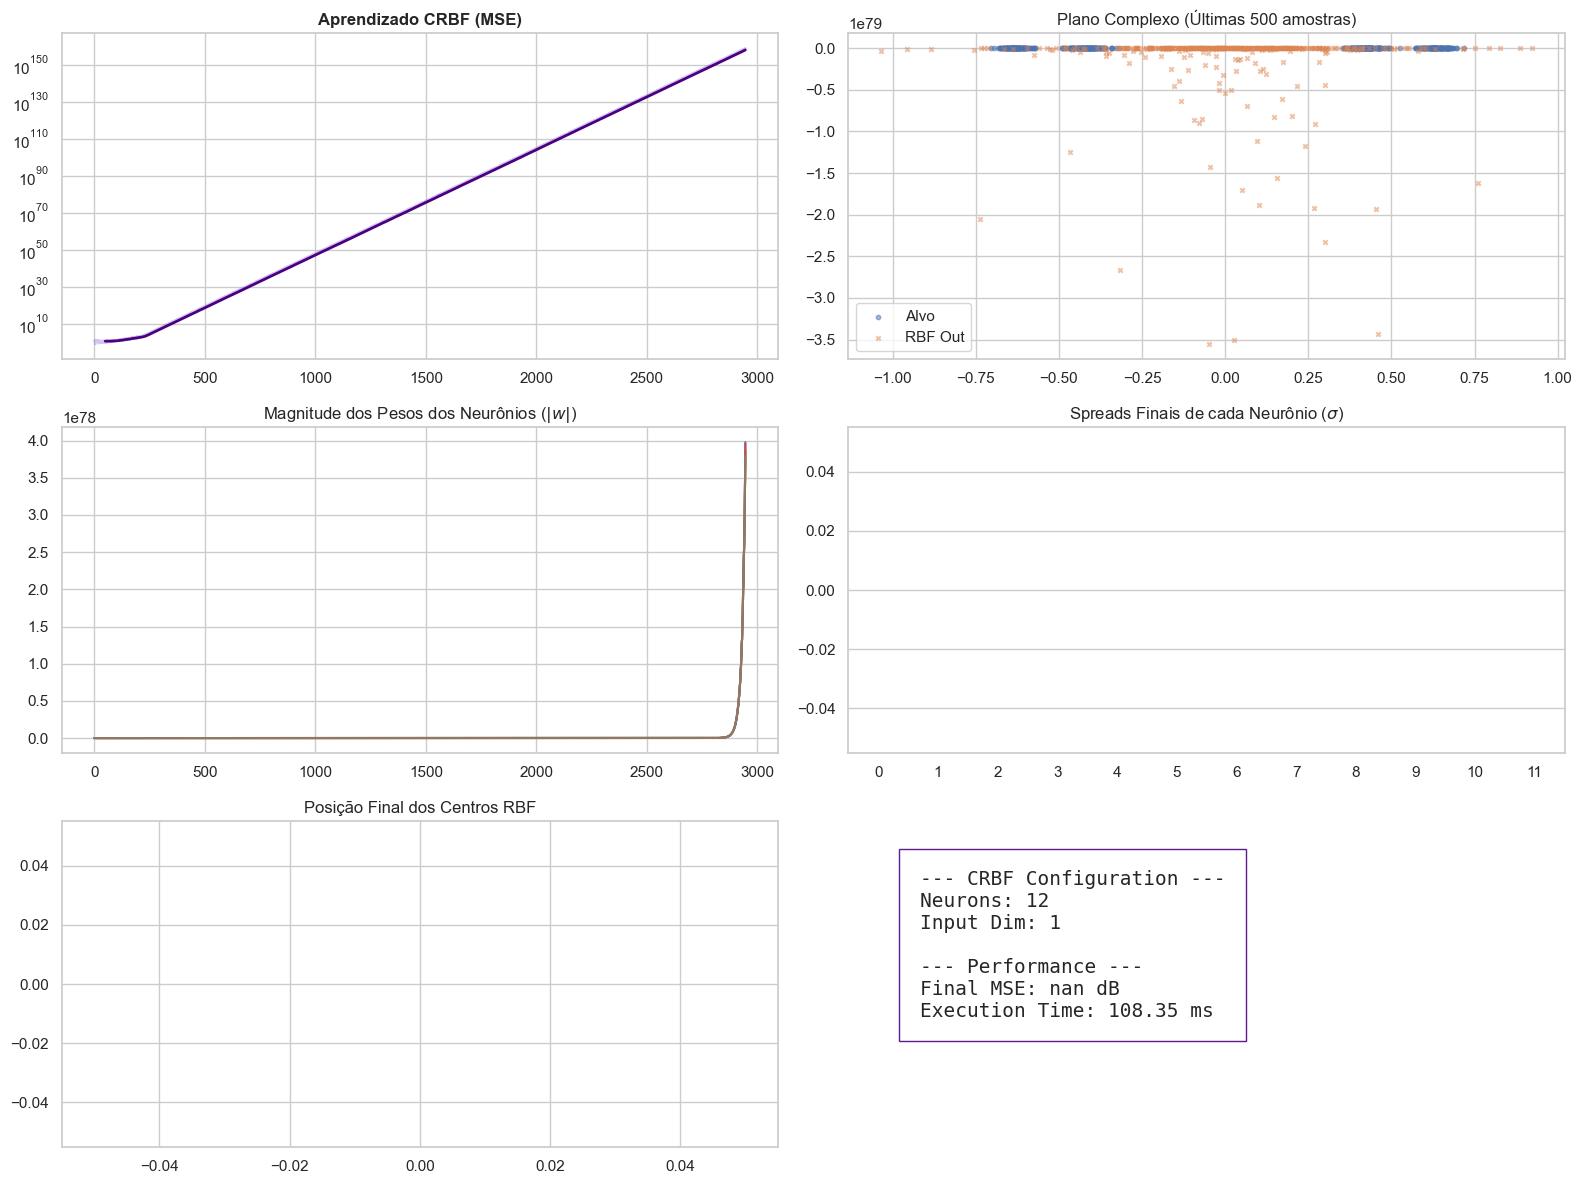

In [19]:
# --- 3. DASHBOARD DE DIAGNÓSTICO ---
def plot_complex_rbf_dashboard(result, title):
    sns.set_theme(style="whitegrid")
    mse = result.mse()
    err = result.errors
    out = result.outputs
    t = np.arange(len(mse))
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2)

    # A. Convergência MSE
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(t, mse, color='mediumpurple', alpha=0.4)
    ax1.semilogy(t, pd.Series(mse).rolling(50).mean(), color='indigo', lw=2)
    ax1.set_title("Aprendizado CRBF (MSE)", fontweight='bold')

    # B. Constelação: Desejado vs Saída
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(d[-500:].real, d[-500:].imag, label='Alvo', alpha=0.5, s=10)
    ax2.scatter(out[-500:].real, out[-500:].imag, label='RBF Out', alpha=0.5, s=10, marker='x')
    ax2.set_title("Plano Complexo (Últimas 500 amostras)")
    ax2.legend()

    # C. Evolução dos Pesos (Magnitude)
    ax3 = fig.add_subplot(gs[1, 0])
    coeffs = np.abs(np.array(result.coefficients)[1:])
    ax3.plot(t, coeffs[:, :6]) # Mostra os primeiros 6 neurônios
    ax3.set_title("Magnitude dos Pesos dos Neurônios ($|w|$)")

    # D. Evolução dos Spreads (Sigma)
    ax4 = fig.add_subplot(gs[1, 1])
    # Como sigma não está no history padrão, pegamos o final do extra
    sigma_final = result.extra['sigma_last']
    sns.barplot(x=list(range(len(sigma_final))), y=sigma_final, ax=ax4, palette="magma", hue=list(range(len(sigma_final))), legend=False)
    ax4.set_title(r"Spreads Finais de cada Neurônio ($\sigma$)")

    # E. Centros no Plano Complexo
    ax5 = fig.add_subplot(gs[2, 0])
    centers = result.extra['centers_last']
    ax5.scatter(centers.real, centers.imag, c='red', marker='D', s=50, label='Centros Finais')
    ax5.set_title("Posição Final dos Centros RBF")
    ax5.grid(True)

    # F. Info Box
    ax6 = fig.add_subplot(gs[2, 1])
    ax6.axis('off')
    time_ms = getattr(result, 'runtime_ms', getattr(result, 'runtime_s', 0) * 1000)
    
    stats_text = (
        f"--- CRBF Configuration ---\n"
        f"Neurons: {result.extra['n_neurons']}\n"
        f"Input Dim: {result.extra['input_dim']}\n\n"
        f"--- Performance ---\n"
        f"Final MSE: {10*np.log10(np.mean(mse[-100:])):.2f} dB\n"
        f"Execution Time: {time_ms:.2f} ms"
    )
    ax6.text(0.1, 0.4, stats_text, fontsize=14, family='monospace', 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='indigo', pad=15))

    plt.tight_layout()
    plt.show()

plot_complex_rbf_dashboard(result, "Complex RBF Diagnostic")